# Data Wrangling

## Imports

In [1]:
#Import the relevant modules
import os
import glob

import pandas as pd
import numpy as np

import datetime as dt

import matplotlib.pyplot as plt

In [2]:
def get_file_name(file_name):
    name_ext = file_name.split("\\")[-1]
    name = name_ext.split(".")[0]
    return name

## Parameters

In [3]:
#Define start and end dates
fromDate = '2000-01-01'
toDate = '2022-09-01'

## Read raw data

In [4]:
#Provide the name of CSV datasets
my_datasets_csv = [
    'eia_data_raw.csv',
    'fred_data_raw.csv',
    'offline_data_raw.csv']

In [5]:
# Change directory one step back and save as the root directory
ROOT_DIR = os.path.normpath(os.getcwd() + os.sep + os.pardir)

# Change direcotry to the 'data\interim' folder
path = ROOT_DIR + '\\data\\raw\\'

#Get the full file names (including directory)
for i in range(len(my_datasets_csv)):
    my_datasets_csv[i] = path + my_datasets_csv[i]

In [6]:
# Initialize list; this is the final list that will store all the data from the json pull. 
data = []

# loop over the list of csv files
for f in my_datasets_csv:
    #print file name
    print(get_file_name(f))
    
    #read the csv file into a new dataframe
    new_data = pd.read_csv(f)
    
    #drop the header
    new_data = new_data.drop(columns = ['Unnamed: 0'])
    
    #filter using from-to-dates
    new_data = new_data.loc[(new_data['Date'] >= fromDate) & (new_data['Date'] <= toDate)]
    
    #print the dataframe shape
    print(new_data.shape)

    data.append(new_data)

eia_data_raw
(273, 20)
fred_data_raw
(273, 8)
offline_data_raw
(273, 6)


## Merge dataframes

In [7]:
#find the df with longest dataseries
max_val = data[0].shape[0]
max_idx = 0

for i in range(len(data)):    
    size = size = data[i].shape[0]
    if size>max_val:
        max_val = size
        max_idx = i

In [8]:
#initiate the df with the the longest timeseries
df = data[max_idx]
for i in range(0, len(data)):
    if i != max_idx:
        df_temp = data[i]
        df = pd.merge_ordered(df, df_temp, on = 'Date')

df.set_index('Date', drop=True, inplace=True)

## Explore features

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 273 entries, 2000-01-01 to 2022-09-01
Data columns (total 31 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   WTI_Price                             273 non-null    float64
 1   Oil_Production_OPEC                   273 non-null    float64
 2   Oil_Production_nonOPEC                273 non-null    float64
 3   Oil_Production_World                  269 non-null    float64
 4   Henry_Hub_NG_Price                    273 non-null    float64
 5   Oil_Production_US                     273 non-null    float64
 6   Petrol_Consumption_OECD               273 non-null    float64
 7   Petrol_Consumption_nonOECD            273 non-null    float64
 8   US_CPI                                273 non-null    float64
 9   US_PPI                                273 non-null    float64
 10  US_PPI_Petroleum                      273 non-null    float64
 11  US_PMI  

## Feature Engineering

In [10]:
# Calcualte additioanl features.
df['WTI_Brent_Price_Spread'] = df['WTI_Price'] - df['Brent_Price']
df['WTI_Crack_Spread'] = 2*df['Refiner_Wholesale_Gasoline_Price'] + df['Refiner_Wholesale_Diesel_Price'] - 3*df['WTI_Price']
df['Brent_Crack_Spread'] = 2*df['Refiner_Wholesale_Gasoline_Price'] + df['Refiner_Wholesale_Diesel_Price'] - 3*df['Brent_Price']

# Drop unnecessary columns
df = df.drop(columns=['Brent_Price', 'Refiner_Wholesale_Gasoline_Price', 'Refiner_Wholesale_Diesel_Price'])

In [11]:
df.head().T

Date,2000-01-01,2000-02-01,2000-03-01,2000-04-01,2000-05-01
WTI_Price,27.259000,29.366000,29.842000,25.722000,28.788000
Oil_Production_OPEC,26.012534,26.675516,26.608782,27.516678,28.048591
Oil_Production_nonOPEC,46.902384,46.822508,46.937266,46.618731,46.623961
Oil_Production_World,73854.239240,74470.542507,74439.049968,75116.129376,75639.562523
Henry_Hub_NG_Price,2.420000,2.660000,2.790000,3.040000,3.590000
Oil_Production_US,5.784376,5.851839,5.918207,5.854166,5.846510
Petrol_Consumption_OECD,47.226772,50.229341,49.358083,46.286749,47.338795
Petrol_Consumption_nonOECD,28.286122,28.770679,28.528547,28.131882,28.216862
US_CPI,1.693000,1.700000,1.710000,1.709000,1.712000
US_PPI,1.293008,1.299187,1.305372,1.311693,1.317793


## Missing data

In [12]:
#Count (using `.sum()`) the number of missing values (`.isnull()`) in each column of 
#ski_data as well as the percentages (using `.mean()` instead of `.sum()`).
#Order them (increasing or decreasing) using sort_values
#Call `pd.concat` to present these in a single table (DataFrame) with the helpful column names 'count' and '%'
missing = pd.concat([df.isnull().sum(), 100 * df.isnull().mean()], axis=1)
missing.columns=['count', '%']
missing.sort_values(by='count', ascending = False)

,count,%
Real_Dollar_Index,72,26.373626
Petroleum_Inventory_OECD,36,13.186813
Oil_Production_World,4,1.465201
EU19_PPI,3,1.098901
Index_Global_Real_Econ_Activity,2,0.732601
US_CPI_Energy,2,0.732601
Global_Econ_Policy_Uncertainty_Index,1,0.366300
WTI_Price,0,0.000000
WTI_Crack_Spread,0,0.000000
WTI_Brent_Price_Spread,0,0.000000


**Note:** It is recommended to find other data sources for the following featuers with more that 10
- Real_Dollar_Index	72	26%
- Petroleum_Inventory_OECD	36	13%

## Explore data

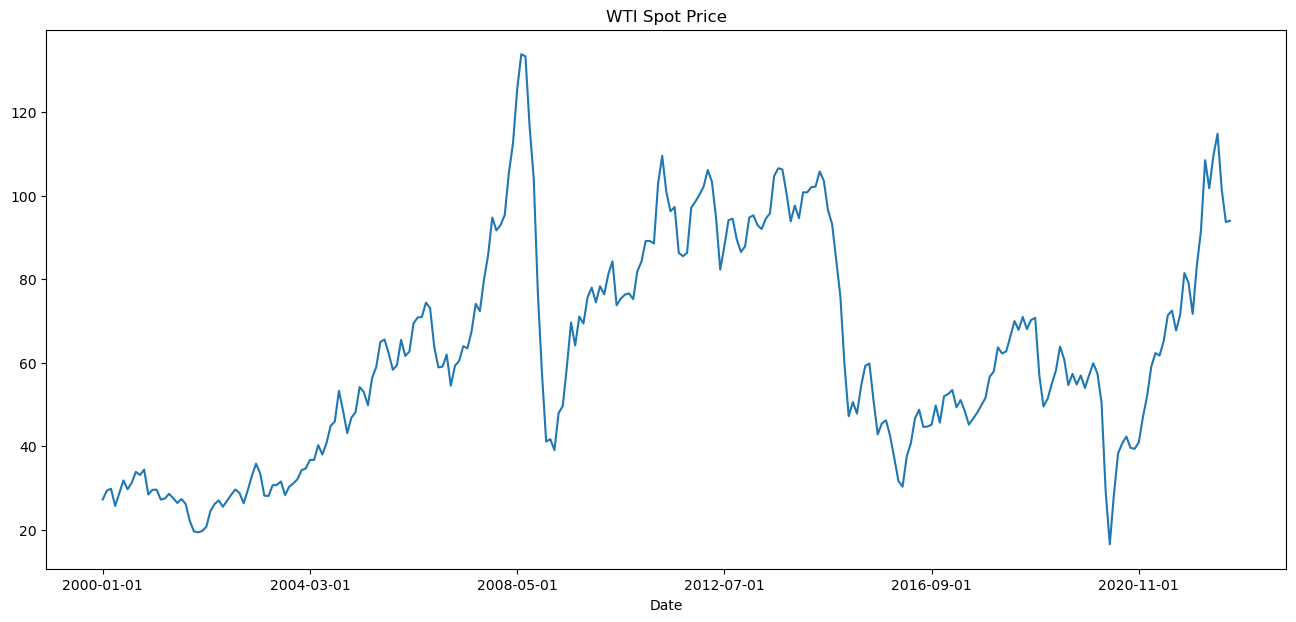

In [13]:
plt.figure(figsize = (16,7))
df['WTI_Price'].plot()
plt.title('WTI Spot Price')
plt.xlabel('Date')
plt.show()

## Store data

In [14]:
# Change directory one step back and save as the root directory
ROOT_DIR = os.path.normpath(os.getcwd() + os.sep + os.pardir)

# Change direcotry to the 'data\raw' folder
path = ROOT_DIR + '\\data\\interim\\'

# Set a file name
file_save = path + 'merged_eia_fred_offile.csv'
df.to_csv(file_save)

print('Save:\n', file_save)

Save:
 D:\gitProjects\springboard_capstone_1\Springboard_Capstone_01\data\interim\merged_eia_fred_offile.csv
